Header

In [13]:
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import cupy as cp
import lenspyx
import pysht
from pysht import get_geom
import delensalot
from delensalot import utils
from ducc0.misc import get_deflected_angles
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs


lmax, mmax = 2047, 2047
ll = np.arange(0,lmax)
lldlm = np.arange(0,lmax+1024)
# geominfo = ('tgl',{'lmax': lmax, 'smax':3})
# geominfo = ('gl',{'lmax':lmax})
solver = 'shtns'
geominfo = ('gl',{'lmax':lmax}) # if solver == 'shtns' else ('cc',{'nphi':4116, 'ntheta':2056})
# geominfo = ('cc',{'nphi':1032, 'ntheta':2058})
# geominfo = ('healpix',{'nside': 512})

synunl = Xunl(lmax=lmax, geominfo=geominfo)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo)

philm = synunl.get_sim_phi(0, space='alm')
dlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))

Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
Tunlmap = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
Tskyalm = synsky.get_sim_sky(0, spin=0, space='alm', field='temperature')

deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}

def flip_tpg_2d(m):
    # FIXME this should probably be lmax, not lmax_dlm
    # dim of m supposedly (2, -1)
    buff = np.array([_.reshape(2*(lmax+1),-1).T.flatten() for _ in m])
    return buff

INFO:: 03-07 17:05:08:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-07 17:05:08:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 03-07 17:05:08:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-07 17:05:08:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ...  3.45999034e-08+7.95018733e-08j
  4.73740393e-09-4.15860204e-08j -5.90108163e-09+8.60753973e-08j]
(1, 2098176) complex128 [[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
   2.26476370e-04+0.00000000e+00j ...  3.45999034e-08+7.95018733e-08j
   4.73740393e-09-4.15860204e-08j -5.90108163e-09+8.60753973e-08j]]
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ...  3.45999034e-08+7.95018733e-08j
  4.73740393e-09-4.15860204e-08j -

# Check calls

## nuFFT test

### CPU

In [3]:
"""
CPU nuFFT
"""
sht_solver = 'shtns' # 'shtns'
geominfo = ('gl',{'lmax':lmax}) #if sht_solver == 'shtns' else ('cc',{'nphi':4116, 'ntheta':2056})
for solver in ['finufft']:
    for backend in ['CPU']:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)
            t_cpu = t
            # print("Testing function synthesis_general...")
            # defres = t.synthesis_general(lmax, mmax, Tsky, [0,1], 0, 1e-5, 4, mode='GRAD_ONLY', verbose=1)
            
            # print("Testing function adjoint_synthesis_general...")
            # defres = t.adjoint_synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)

            print("\n----Testing function gclm2lenmap...----")
            defres = t.gclm2lenmap(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)

            print("\n----Testing function lenmap2gclm...----")
            defres = t.lenmap2gclm(points=Tsky.copy(), dlm=dlm, spin=0, lmax=lmax, mmax=lmax, nthreads=4)
            
            print("\n----Testing function lensgclm...----")
            defres = t.lensgclm(Tunl.copy(), spin=0, dlm=dlm, lmax_out=lmax, nthreads=4)

            print('\n\n')

Testing solver=finufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----


/mnt/home/sbelkner/git/pySHT/pysht/deflection/CPU_nufft_transformer.py:102: RuntimeWarning: divide by zero encountered in divide
  synth_spin1_map = self.synthesis_der1(hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1))))), nthreads=4)
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: U


----Testing function lenmap2gclm...----

----Testing function lensgclm...----


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc

### GPU

In [2]:
"""
GPU nuFFT
"""
sht_solver = 'shtns' # shtns
geominfo = ('gl',{'lmax':lmax}) #if sht_solver == 'shtns' else ('cc',{'nphi':4116, 'ntheta':2056})
for solver in ['cufinufft']:
    for backend in ['GPU']:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)
            t_gpu = t
            # t.set_geometry(geominfo)
            print("\n----Testing function gclm2lenmap...----")
            defres = t.gclm2lenmap(gclm=Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)

            print("\n----Testing function lenmap2gclm...----")
            defres = t.lenmap2gclm(points=Tsky.copy(), dlm=dlm, spin=0, lmax=lmax, mmax=lmax, nthreads=4)
            
            print("\n----Testing function lensgclm...----")
            defres = t.lensgclm(Tunl.copy(), spin=0, lmax_out=lmax, dlm=dlm, nthreads=4)

            # print("Testing function synthesis_general...")
            # defres = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            # print("Testing function adjoint_synthesis_general...")
            # defres = t.adjoint_synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')

Testing solver=cufinufft backend=GPU mode=nuFFT...
deflection std is 2.68e+00 amin

----Testing function gclm2lenmap...----
_build_d1()


/mnt/home/sbelkner/git/pySHT/pysht/deflection/GPU_nufft_transformer.py:372: RuntimeWarning: divide by zero encountered in divide
  synth_spin1_map = self.synthesis_der1(hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1))))), nthreads=4)


get_ptg
(8388608,)

----Testing function lenmap2gclm...----
get_ptg
Nu2u:
  nthreads=4, grid=(4114x4096), oversampled grid=(5376x5346), supp=12, eps=1e-07
  npoints=8388608
  memory overhead: 0.03125GB (index) + 0.428261GB (oversampled grid)

Total wall clock time for nu2u: 0.7616s
|
+- nu2u proper          : 91.51% (0.6969s)
|  |
|  +- spreading            : 70.98% (0.4947s)
|  +- FFT                  : 21.59% (0.1505s)
|  +- grid correction      :  3.90% (0.0272s)
|  +- zeroing grid         :  3.52% (0.0245s)
|  +- allocating grid      :  0.00% (0.0000s)
|  
+- building index       :  8.39% (0.0639s)
+- correction factors   :  0.06% (0.0005s)
+- parameter calculation:  0.00% (0.0000s)

----Testing function lensgclm...----
_build_d1()
get_ptg
(8388608,)





## SHT test

### CPU

In [7]:

"""
CPU SHT
"""
for solver in ['shtns', 'ducc']:
    for backend in ['CPU']:
        for mode in ['SHT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)(geominfo)

            print("Testing function synthesis_general...")
            defres = t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            print("Testing function adjoint_synthesis_general...")
            if solver == 'shtns':
                m = np.random.random(size=t.constructor.spat_shape)
            else:
                m = Tsky
            defres = t.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')

Testing solver=shtns backend=CPU mode=SHT...
Testing function synthesis_general...
Testing function adjoint_synthesis_general...



Testing solver=ducc backend=CPU mode=SHT...
Testing function synthesis_general...
Testing function adjoint_synthesis_general...





### GPU

In [8]:
"""
GPU SHT
"""
for solver in ['shtns']:
    for backend in ['GPU']:
        for mode in ['SHT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)(geominfo)

            print("Testing function synthesis_general...")
            defres = t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            print("Testing function adjoint_synthesis_general...")
            if solver == 'shtns':
                m = np.random.random(size=t.constructor.spat_shape)
            else:
                m = Tsky
            defres = t.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')

Testing solver=shtns backend=GPU mode=SHT...
Testing function synthesis_general...
Testing function adjoint_synthesis_general...





# Check output
## deflection

Testing solver=finufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----
(2, 8851680)


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc




Testing solver=duccnufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----
(2, 8851680)



Testing solver=lenspyx backend=CPU mode=nuFFT...
{'sig_d': 0.0007682575305516957, 'dlm': array([ 0.00000000e+00+0.00000000e+00j,  1.38034496e-04+0.00000000e+00j,
        2.26476370e-04+0.00000000e+00j, ...,
       -3.24791627e-08-2.23143778e-08j, -6.50468410e-08+9.93322861e-09j,
        6.94855761e-08-1.10898411e-08j]), 'dclm': None, 'lmax_dlm': 2048, 'mmax_dlm': 2048, 'cacher': <lenspyx.cachers.cacher_mem object at 0x155549e0f3d0>, 'geom': <lenspyx.remapping.utils_geom.Geom object at 0x155549e0c580>, 'pbgeom': <lenspyx.remapping.utils_geom.pbdGeometry object at 0x1554cbb689a0>, 'sht_tr': 4, 'verbosity': 0, 'epsilon': 1e-05, 'single_prec': 0, 'single_prec_ptg': False, 'tim': <lenspyx.utils.timer object at 0x155444237670>, 'planned': False, 'plans': {}, '_totalconvolves0': False, 'ofactor': 1.5, '_cis': False}

----Testing function gclm2lenmap...----
[ 0.00000000e+00+0.00000000

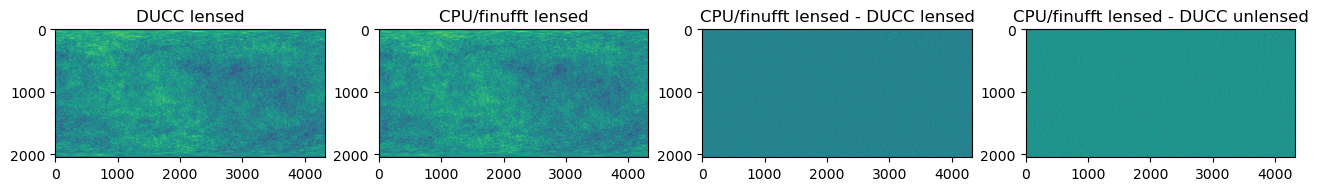

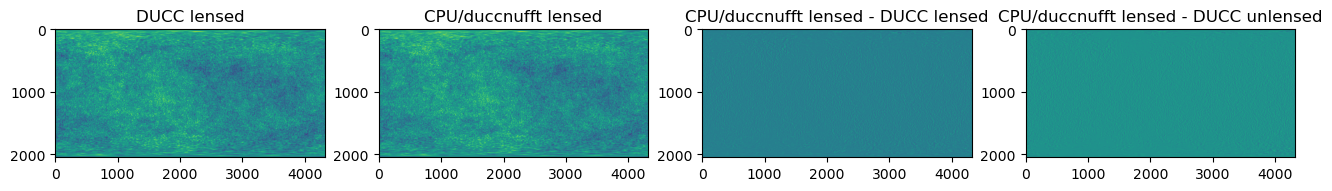

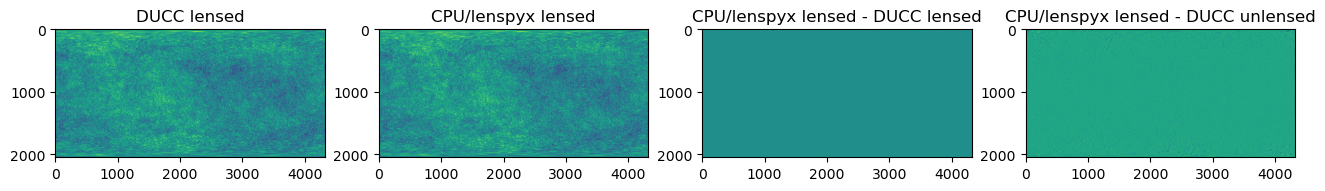

In [2]:
"""
gclm2lenmap
"""
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}


for backend in ['CPU']:
    if backend == 'GPU':
        solvers = ['cufinufft']
        sht_solver = 'shtns' # 'shtns'
    elif backend == 'CPU':
        solvers = ['finufft', 'duccnufft', 'lenspyx']
        sht_solver = 'ducc' # 'shtns'

    for solver in solvers:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            print("\n----Testing function gclm2lenmap...----")
            defres = t.gclm2lenmap(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            fig, ax = plt.subplots(1,4,figsize=(16,6))
            ax[0].imshow(Tsky.reshape(lmax+1,-1))
            ax[0].set_title('DUCC lensed'.format(solver=solver))
            ax[1].imshow(defres.reshape(lmax+1,-1))
            ax[1].set_title('{backend}/{solver} lensed'.format(solver=solver, backend=backend))
            ax[2].imshow((Tsky-defres).reshape(lmax+1,-1))
            ax[2].set_title('{backend}/{solver} lensed - DUCC lensed'.format(solver=solver, backend=backend))
            ax[3].imshow((Tunlmap-defres).reshape(lmax+1,-1))
            ax[3].set_title('{backend}/{solver} lensed - DUCC unlensed'.format(solver=solver, backend=backend))

            print('\n\n')

Testing solver=lenspyx backend=CPU mode=nuFFT...
{'sig_d': 2.0171306531598067e-28, 'dlm': array([ 0.00000000e+00+0.00000000e+00j,  9.76051284e-29+0.00000000e+00j,
        9.24585909e-29+0.00000000e+00j, ...,
       -1.58628394e-35-1.08983534e-35j, -3.17534015e-35+4.84902558e-36j,
        3.39202236e-35-5.41363997e-36j]), 'dclm': None, 'lmax_dlm': 2048, 'mmax_dlm': 2048, 'cacher': <lenspyx.cachers.cacher_mem object at 0x155447e6f910>, 'geom': <lenspyx.remapping.utils_geom.Geom object at 0x155447e0fd30>, 'pbgeom': <lenspyx.remapping.utils_geom.pbdGeometry object at 0x1554e09df670>, 'sht_tr': 4, 'verbosity': 0, 'epsilon': 1e-05, 'single_prec': 0, 'single_prec_ptg': False, 'tim': <lenspyx.utils.timer object at 0x155465e22e90>, 'planned': False, 'plans': {}, '_totalconvolves0': False, 'ofactor': 1.5, '_cis': False}

----Testing function lenmap2gclm...----
geom name: gl
[ 0.00000000e+00+0.00000000e+00j  9.76051284e-29+0.00000000e+00j
  9.24585909e-29+0.00000000e+00j ... -1.58628394e-35-1.089

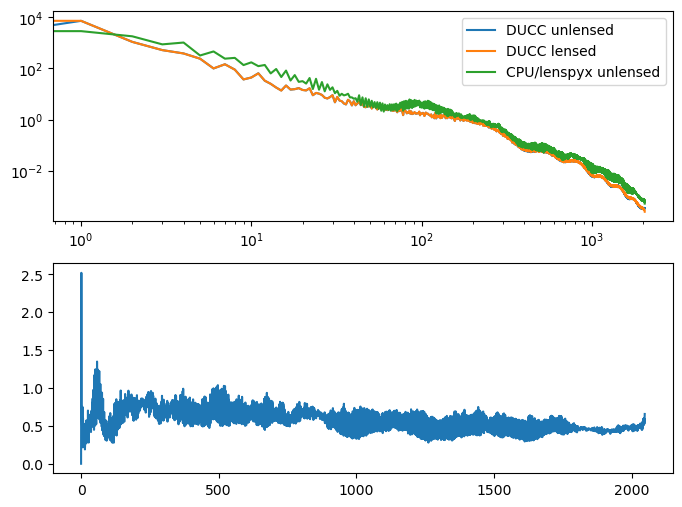

In [10]:
import healpy as hp
"""
lenmap2gclm
"""
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm*1e-24,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False,
    'sht_mode':'GRAD_ONLY'
    }
backend = 'CPU'
if backend == 'GPU':
    solvers = ['cufinufft']
elif backend == 'CPU':
    solvers = ['lenspyx']
sht_solver = 'ducc' # 'shtns'


for solver in solvers:
    fig, ax = plt.subplots(2,1,figsize=(8,6))
    for mode in ['nuFFT']:
        print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
        t = pysht.get_transformer(solver, mode, backend)
        t = t(sht_solver, geominfo, deflection_kwargs)

        print("\n----Testing function lenmap2gclm...----")
        defres = t.lenmap2gclm(points=Tsky.copy(), dlm=dlm, spin=0, lmax=lmax, mmax=lmax, nthreads=4)
        
        ax[0].plot(hp.alm2cl(Tunl), label='DUCC unlensed')
        ax[0].plot(hp.alm2cl(Tskyalm), label='DUCC lensed')
        ax[0].plot(hp.alm2cl(defres)*1e-12, label='{backend}/{solver} unlensed'.format(solver=solver, backend=backend))
        ax[1].plot(hp.alm2cl(Tunl)/hp.alm2cl(defres)*1e12, label='DUCC - {backend}/{solver} unlensed'.format(solver=solver, backend=backend))
    ax[0].loglog()
    ax[0].legend()
    plt.show()

/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc

** gclm2lenmap: inconsistent input dtype !
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
 -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
(1, 2100225) complex128 [[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
   2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
  -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]]
deflection std is 2.64e+00 amin
deflection std is 2.64e+00 amin
build_angles


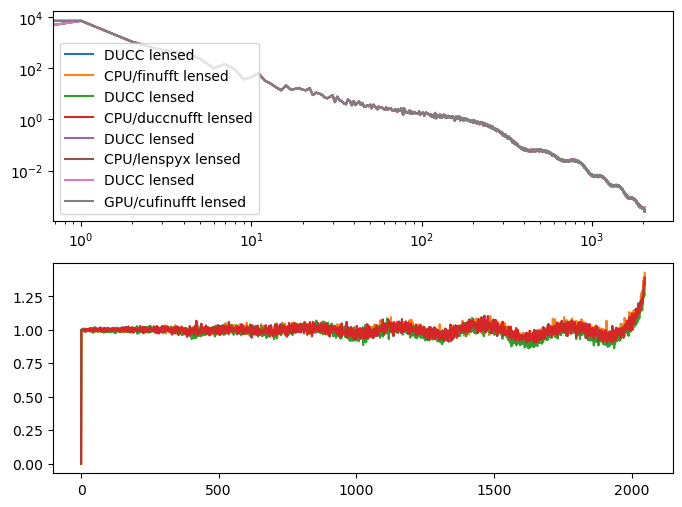

In [ ]:
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}

fig, ax = plt.subplots(2,1,figsize=(8,6))
for backend in ['CPU', 'GPU']:
    if backend == 'GPU':
        solvers = ['cufinufft']
    elif backend == 'CPU':
        solvers = ["finufft", "duccnufft", "lenspyx"] #   
    sht_solver = 'ducc' # 'shtns'
    for solver in solvers:
        for mode in ['nuFFT']:
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            defres = t.lensgclm(Tunl.copy(), spin=0, dlm=dlm, lmax_out=lmax, nthreads=4)
                
            ax[0].plot(hp.alm2cl(Tunl), label='DUCC lensed')
            ax[0].plot(hp.alm2cl(defres.astype(complex)), label='{backend}/{solver} lensed'.format(solver=solver, backend=backend))
            ax[1].plot(hp.alm2cl(Tunl)/hp.alm2cl(defres.astype(complex)), label='DUCC - {backend}/{solver} lensed'.format(solver=solver, backend=backend))
        ax[0].loglog()
        ax[0].legend()
plt.show()

## SHT

('cc', {'nphi': 4116, 'ntheta': 2056})
('gl', {'lmax': 2048})
-0.03758332731607735


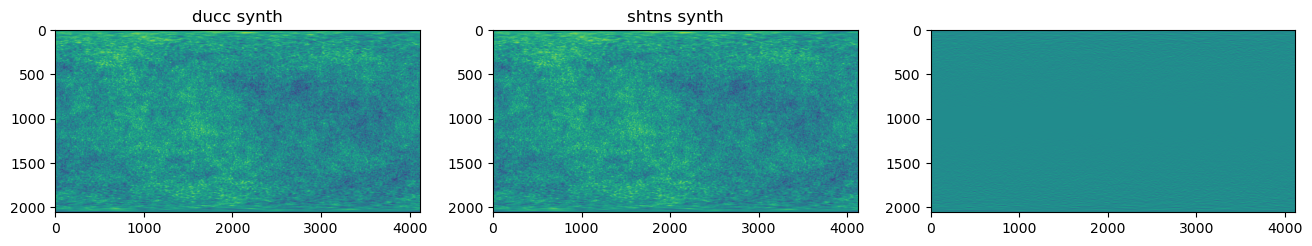

In [75]:
backend = 'CPU'
if backend == 'GPU':
    solvers = ['shtns']
elif backend == 'CPU':
    solvers = ['ducc', 'shtns']

defres = []
fig, ax = plt.subplots(1,3,figsize=(16,6))
for solveri, solver in enumerate(solvers):
    for mode in ['SHT']:
        geominfo = ('gl',{'lmax':lmax}) if solver == 'shtns' else ('cc',{'nphi':4116, 'ntheta':2056})
        t = pysht.get_transformer(solver, mode, backend)
        t = t(geominfo)
        print(geominfo)
        defres.append(t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4))
        if solver == 'ducc':
            ax[solveri].imshow(defres[solveri].reshape(2056,-1))
        else:
            ax[solveri].imshow(defres[solveri].reshape(-1,2056).T)
        ax[solveri].set_title('{solver} synth'.format(solver=solver))
diff = defres[0].reshape(2056,-1)-defres[1].reshape(-1,2056).T
ax[2].imshow(diff)
print(np.mean(diff))

## Spin-1 vs. synth_derivative


In [ ]:
def test_sharp_alm2map_der1():
 
    # Test the wrapper around libsharps alm2map_der1.
    lmax = 3
    nside = 32
    spin = 1

    # Test different input shapes and dtypes.
    # Case 1a: 1d double precision.
    alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    alm[4] = 1. + 1.j

    omap = hp.alm2map_der1(alm, nside=nside)
    # Compare to expected value by doing spin 1 transform
    # on sqrt(ell (ell + 1)) alm.
    alm_spin = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    alm_spin = alm * np.sqrt(2)
    # omap_exp = hp.alm2map_spin(alm_spin, nside, spin, lmax)

    # np.testing.assert_array_almost_equal(omap, omap_exp)
    print(omap.shape)
    
test_sharp_alm2map_der1()

('gl', {'lmax': 2047}) [4096 4096 4096 ... 4096 4096 4096] 2048


/tmp/ipykernel_2320109/3627493065.py:9: RuntimeWarning: divide by zero encountered in divide
  deriv1shtns = tshtns.synthesis_der1(hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(lldlm*(lldlm+1))))), nthreads=4)


(2, 8388608)


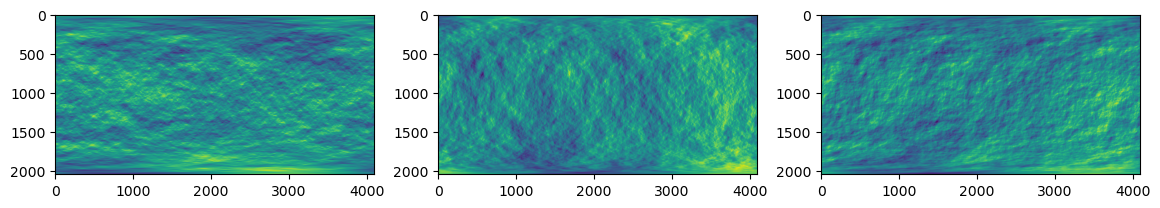

In [9]:
fig, ax = plt.subplots(1,3,figsize=(14,6))

solver = 'shtns'
geominfo = ('gl',{'lmax':lmax}) if solver == 'shtns' else ('cc',{'nphi':4096, 'ntheta':2048})
tshtns = pysht.get_transformer(solver, 'SHT', 'CPU')
tshtns = tshtns(geominfo)
print(geominfo, tshtns.geom.nph, len(tshtns.geom.nph))
# deriv1shtns = tshtns.synthesis_der1(philm, nthreads=4)
deriv1shtns = tshtns.synthesis_der1(hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(lldlm*(lldlm+1))))), nthreads=4)
print(deriv1shtns.shape)
ax[0].imshow(deriv1shtns[0].reshape(*tshtns.constructor.spat_shape).T)
ax[1].imshow(deriv1shtns[1].reshape(*tshtns.constructor.spat_shape).T)
ax[2].imshow(deriv1shtns[0].reshape(*tshtns.constructor.spat_shape).T+deriv1shtns[1].reshape(*tshtns.constructor.spat_shape).T)

deriv1shtns_ = flip_tpg_2d(deriv1shtns)

('gl', {'lmax': 2047})
(2, 8388608)


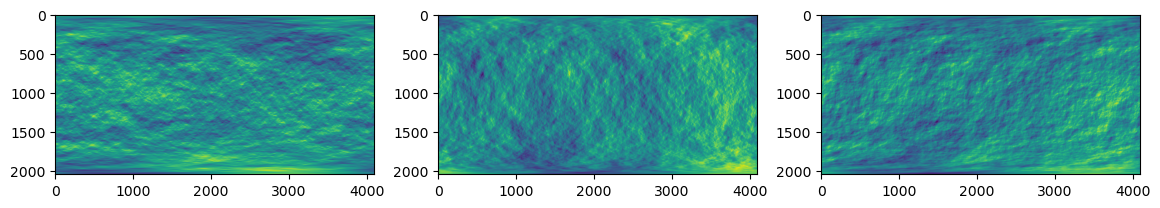

In [10]:
fig, ax = plt.subplots(1,3,figsize=(14,6))

philm = synunl.get_sim_phi(0, space='alm')
dlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))
solver = 'ducc'
geominfo = ('gl',{'lmax':lmax}) # if solver == 'shtns' else ('cc',{'nphi':4096, 'ntheta':2048})
print(geominfo)
tducc = pysht.get_transformer(solver, 'SHT', 'CPU')
tducc = tducc(geominfo)
deriv1ducc = tducc.synthesis(dlm, spin=1, lmax=lmax, mmax=mmax, nthreads=4, mode='GRAD_ONLY')
print(deriv1ducc.shape)
ax[0].imshow(deriv1ducc[0].reshape(-1,tducc.geom.nph[0]))
ax[1].imshow(deriv1ducc[1].reshape(-1,tducc.geom.nph[0]))
ax[2].imshow(deriv1ducc[0].reshape(-1,tducc.geom.nph[0])+deriv1ducc[1].reshape(-1,tducc.geom.nph[0]))

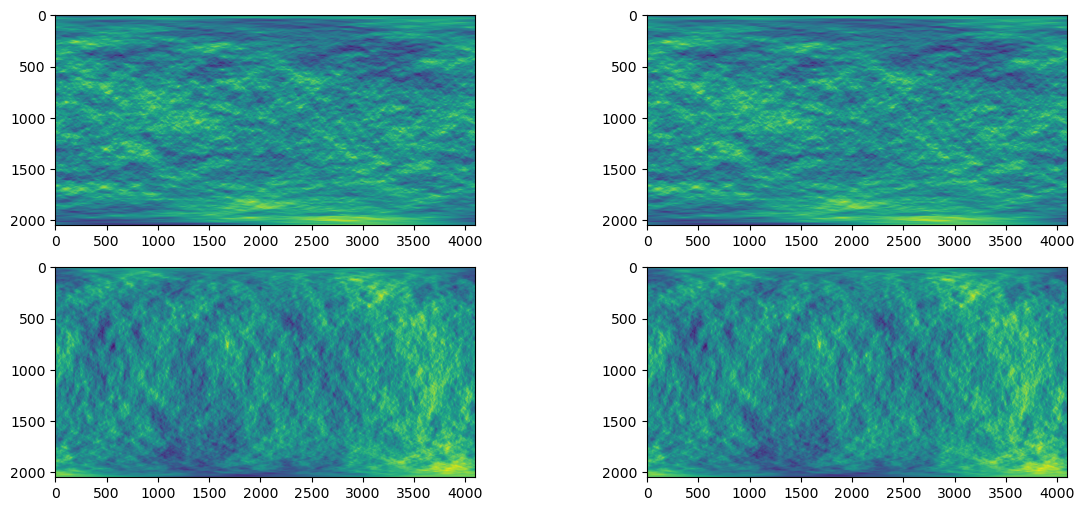

In [11]:
fig, ax = plt.subplots(2,2,figsize=(14,6))
for i, (a, b) in enumerate(zip(deriv1ducc, deriv1shtns_)):
    ax[i,0].imshow(a.reshape(2048,-1))
    ax[i,1].imshow(b.reshape(2048,-1))
    

def flip_tpg_2d(m):
    # dim of m supposedly (2, -1)
    buff = np.array([_.reshape(2*(lmax+1),-1).T.flatten() for _ in m])
    return buff

## Check get_deflected_angles from DUCC for both SHTns and ducc pointing maps

In [14]:
tht, phi0, nph, ofs = tshtns.geom.theta, tshtns.geom.phi0, tshtns.geom.nph, tshtns.geom.ofs
print(tht, phi0, nph, ofs)
tht_phip_gamma_shtns = get_deflected_angles(theta=tht, phi0=phi0, nphi=nph, ringstart=ofs, deflect=deriv1shtns_.T,
                                        calc_rotation=False, nthreads=4)

[1.17394461e-03 2.69469273e-03 4.22442169e-03 ... 3.13736823e+00
 3.13889796e+00 3.14041871e+00] [0. 0. 0. ... 0. 0. 0.] [4096 4096 4096 ... 4096 4096 4096] [      0    4096    8192 ... 8376320 8380416 8384512]


In [15]:
tht, phi0, nph, ofs = tducc.geom.theta, tducc.geom.phi0, tducc.geom.nph, tducc.geom.ofs
print(tht, phi0, nph, ofs)
tht_phip_gamma_ducc = get_deflected_angles(theta=tht, phi0=phi0, nphi=nph, ringstart=ofs, deflect=deriv1ducc.T,
                                        calc_rotation=False, nthreads=4)

[1.17394461e-03 2.69469273e-03 4.22442169e-03 ... 3.13736823e+00
 3.13889796e+00 3.14041871e+00] [0. 0. 0. ... 0. 0. 0.] [4096 4096 4096 ... 4096 4096 4096] [      0    4096    8192 ... 8376320 8380416 8384512]


In [16]:
print(tht_phip_gamma_ducc.shape, tht_phip_gamma_shtns.shape)
print(deriv1shtns.shape, deriv1ducc.shape)

(8388608, 2) (8388608, 2)
(2, 8388608) (2, 8388608)


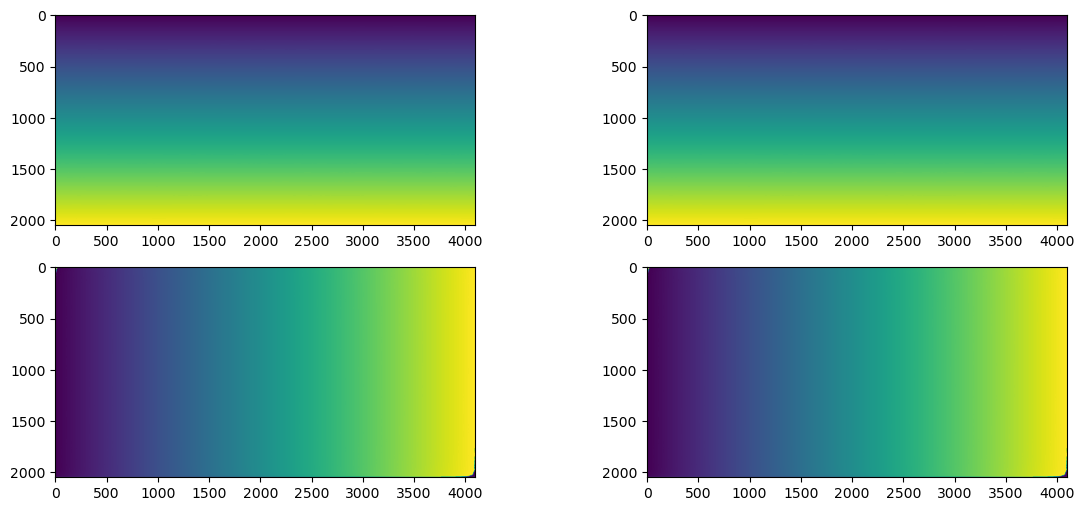

In [17]:
fig, ax = plt.subplots(2,2,figsize=(14,6))
for i, (a, b) in enumerate(zip(tht_phip_gamma_ducc.T, tht_phip_gamma_shtns.T)):
    ax[i,0].imshow(a.reshape(2048,-1))
    ax[i,1].imshow(b.reshape(2048,-1))

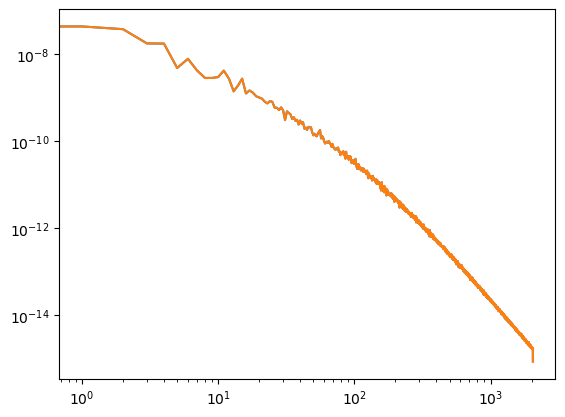

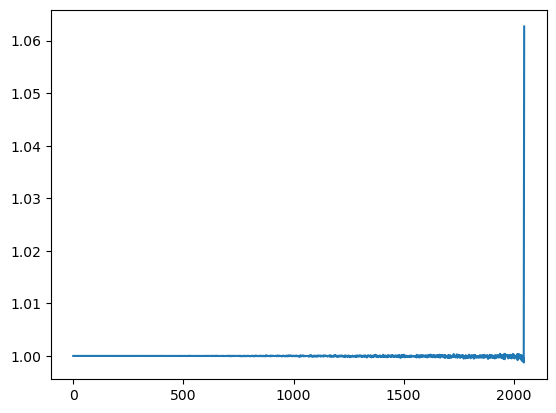

In [16]:
plt.plot(hp.alm2cl(tducc.adjoint_synthesis(deriv1ducc[0].flatten(), spin=0, lmax=lmax, mmax=mmax, nthreads=4)[0]))
plt.plot(hp.alm2cl(tshtns.adjoint_synthesis(deriv1shtns[0].flatten(), spin=0, lmax=lmax, mmax=mmax, nthreads=4)[0]))
plt.loglog()
plt.show()
plt.plot(hp.alm2cl(tducc.adjoint_synthesis(deriv1ducc[0].flatten(), spin=0, lmax=lmax, mmax=mmax, nthreads=4)[0])/hp.alm2cl(tshtns.adjoint_synthesis(deriv1shtns[0].flatten(), spin=0, lmax=lmax, mmax=mmax, nthreads=4)[0]))

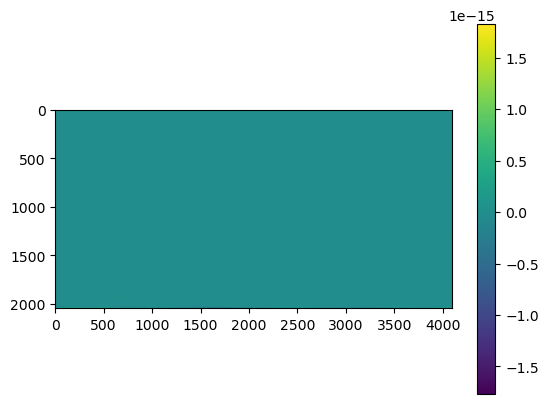

2.043617182191998e-12


In [21]:
# Deflection maps look very similar

# vmin, vmax = -1e-4, 1e-4
buff = deriv1shtns[0].reshape(*tshtns.constructor.spat_shape).T
# for thetarow in buff:
    # buff *= np.sin(theta)
plt.imshow((deriv1ducc[0]).reshape(-1,tducc.geom.nph[0])-buff)
plt.colorbar()
plt.show()
print(np.sum((deriv1ducc[0]).reshape(-1,tducc.geom.nph[0])-buff))

In [19]:
import ducc0

# transform slm to Clenshaw-Curtis map
ntheta = ducc0.fft.good_size(lmax + 2)
nphihalf = ducc0.fft.good_size(lmax + 1)
nphi = 2 * nphihalf
spin=0
gclm = np.atleast_2d(Tunl.copy())

def ducc_sht_mode(gclm, spin):
    gclm_ = np.atleast_2d(gclm)
    return 'GRAD_ONLY' if ((gclm_[0].size == gclm_.size) * (abs(spin) > 0)) else 'STANDARD'

m = ducc0.sht.experimental.synthesis_2d(alm=gclm, ntheta=ntheta, nphi=nphi, spin=spin, lmax=lmax, mmax=lmax, geometry="CC", nthreads=4, mode=ducc_sht_mode(gclm, spin))
print(m.shape)

(1, 2058, 4096)


In [20]:
geominfo = ('cc',{'nphi':4096, 'ntheta':2058})
tducccc = pysht.get_transformer('ducc', 'SHT', 'CPU')(geominfo)
%timeit m_ = tducccc.synthesis(gclm, spin=0, lmax=lmax, mmax=mmax, nthreads=4).reshape(2058,-1)

273 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
def doubling():
    map_dfs = np.empty((2 * ntheta - 2, nphi), dtype=np.complex128 if spin == 0 else ctype[m.dtype])
    if spin == 0:
        map_dfs[:ntheta, :] = m[0]
    else:
        map_dfs[:ntheta, :].real = m[0]
        map_dfs[:ntheta, :].imag = m[1]

    map_dfs[ntheta:, :nphihalf] = map_dfs[ntheta - 2:0:-1, nphihalf:]
    map_dfs[ntheta:, nphihalf:] = map_dfs[ntheta - 2:0:-1, :nphihalf]
    if (spin % 2) != 0:
        map_dfs[ntheta:, :] *= -1
    return map_dfs
        
%timeit doubling()
map_dfs = doubling()

81.2 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
tmp = np.empty(map_dfs.T.shape, dtype=np.complex128)
%timeit ducc0.fft.c2c(map_dfs.T, axes=(0, 1), inorm=2, nthreads=4, out=tmp)

147 ms ± 573 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [75]:
def fft_c2c(m_):
    if spin == 0:
        tmp = np.empty(m_.T.shape, dtype=np.complex128)
        m_ = ducc0.fft.c2c(m_.T, axes=(0, 1), inorm=2, nthreads=4, out=tmp)
        del tmp
    else:
        m_ = ducc0.fft.c2c(m_, axes=(0, 1), inorm=2, nthreads=4, out=m_)
    return m_
# %timeit fft_c2c(map_dfs)

res = fft_c2c(map_dfs)

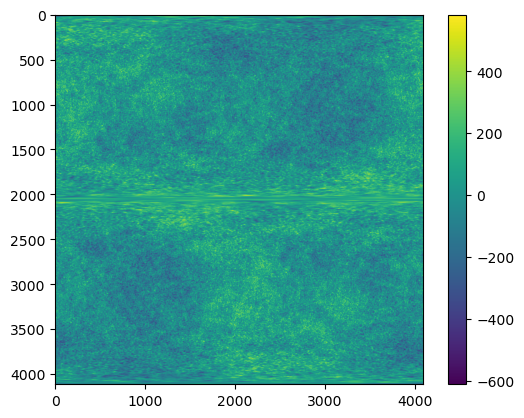

In [79]:
plt.imshow(np.real(np.fft.fftshift(map_dfs, axes=(0,1))))
plt.colorbar()

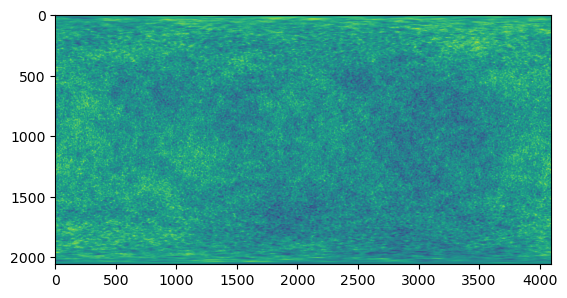

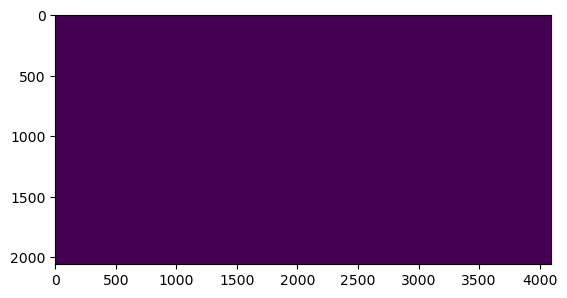

In [50]:
plt.imshow(map[0])
plt.show()
plt.imshow(m_[0].reshape(2058,-1)-map[0])

(4112,)

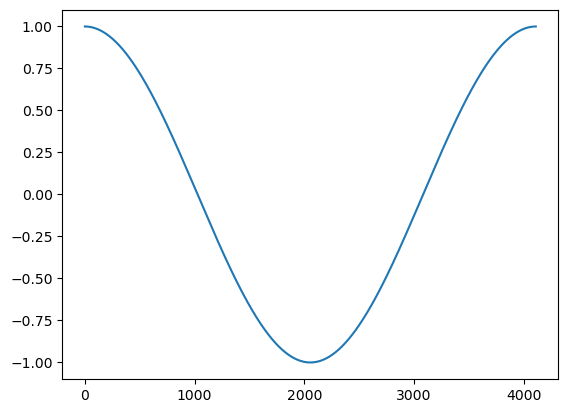

In [56]:
weights = np.concatenate([tshtns.constructor.gauss_wts(), tshtns.constructor.gauss_wts()[::-1]])
weights = np.concatenate([tshtns.constructor.cos_theta, tshtns.constructor.cos_theta[::-1]])
plt.plot(weights)
weights.shape

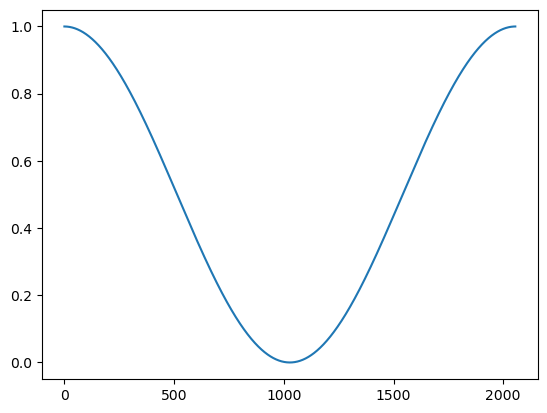

In [28]:
plt.plot(tshtns.constructor.cos_theta**2)